In [1]:
import pandas as pd
import graphviz
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
#Lectura del csv
data_raw=pd.read_csv('ins_covid.csv',index_col=0, sep=';')
data_raw.head()

,fecha_de_notificaci_n,codigo_divipola,ciudad_de_ubicaci_n,departamento,atenci_n,edad,sexo,tipo,estado,pa_s_de_procedencia,fis,fecha_de_muerte,fecha_diagnostico,fecha_recuperado,fecha_reporte_web
id_de_caso,,,,,,,,,,,,,,,
1,2020-03-02T00:00:00.000,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,Italia,2020-02-27T00:00:00.000,- -,2020-03-06T00:00:00.000,2020-03-13T00:00:00.000,2020-03-06T00:00:00.000
2,2020-03-06T00:00:00.000,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,España,2020-03-04T00:00:00.000,- -,2020-03-09T00:00:00.000,2020-03-19T00:00:00.000,2020-03-09T00:00:00.000
3,2020-03-07T00:00:00.000,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,España,2020-02-29T00:00:00.000,- -,2020-03-09T00:00:00.000,2020-03-15T00:00:00.000,2020-03-09T00:00:00.000
4,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,Colombia,2020-03-06T00:00:00.000,- -,2020-03-11T00:00:00.000,2020-03-26T00:00:00.000,2020-03-11T00:00:00.000
5,2020-03-09T00:00:00.000,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,Colombia,2020-03-08T00:00:00.000,- -,2020-03-11T00:00:00.000,2020-03-23T00:00:00.000,2020-03-11T00:00:00.000


In [3]:
#Creación de nuevas variables para filtrar los casos que ya han terminado
data_raw['recup_bin']=data_raw['fecha_recuperado'].apply(pd.notna)
data_raw['muerto_bin']=data_raw['fecha_de_muerte'].apply(pd.notna)
data_raw['terminado_bin']= data_raw['recup_bin'] | data_raw['muerto_bin']
data_raw['terminado_bin'].head()

id_de_caso
1    True
2    True
3    True
4    True
5    True
Name: terminado_bin, dtype: bool

In [4]:
#Creación de los datos para el árbol
data=data_raw[['edad','sexo','estado','terminado_bin']]
data=data[data['terminado_bin']]
data=data[data['estado'].apply(pd.notna)]
del data['terminado_bin']
data.head()

,edad,sexo,estado
id_de_caso,,,
1,19,F,Leve
2,34,M,Leve
3,50,F,Leve
4,55,M,Leve
5,25,M,Leve


In [5]:
#Creamos datos simplificados en caso de que se enfoque mucho en los casos 'vivos' y no en los 'fallecidos'
X=data[['edad','sexo']]
y=data['estado']
y_simp=y.apply(lambda x: 'muerto' if x == 'Fallecido' else 'vivo')
y_simp.head()

id_de_caso
1    vivo
2    vivo
3    vivo
4    vivo
5    vivo
Name: estado, dtype: object

In [6]:
y.head()

id_de_caso
1    Leve
2    Leve
3    Leve
4    Leve
5    Leve
Name: estado, dtype: object

In [7]:
#División en conjuntos de entrenamiento y validación
le=LabelEncoder()
X['sexo']=le.fit_transform(X['sexo'])
X_train, X_val, y_train, y_val, y_simp_train, y_simp_val = train_test_split(
    X , y, y_simp, test_size=0.2, random_state=2204)

C:\Users\Juanj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
#Creación y entrenamiento de los clasificadores
tree_depth=2
crit='gini'
cl=tree.DecisionTreeClassifier(random_state = 2204, criterion = crit, max_depth = tree_depth)
cl_simp=tree.DecisionTreeClassifier(random_state = 2204, criterion = crit, max_depth = tree_depth)
cl.fit(X_train, y_train)
cl_simp.fit(X_train, y_simp_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2204, splitter='best')

In [9]:
#Obtención de las métricas
preds=cl.predict(X_val)
preds_simp=cl_simp.predict(X_val)
print(classification_report(y_true=y_val,y_pred=preds))
print(classification_report(y_true=y_simp_val,y_pred=preds_simp))

              precision    recall  f1-score   support

   Fallecido       0.00      0.00      0.00        51
       Grave       0.00      0.00      0.00        24
        Leve       0.88      1.00      0.94      1092
    Moderado       0.00      0.00      0.00        74
        leve       0.00      0.00      0.00         1

    accuracy                           0.88      1242
   macro avg       0.18      0.20      0.19      1242
weighted avg       0.77      0.88      0.82      1242

              precision    recall  f1-score   support

      muerto       0.33      0.02      0.04        51
        vivo       0.96      1.00      0.98      1191

    accuracy                           0.96      1242
   macro avg       0.65      0.51      0.51      1242
weighted avg       0.93      0.96      0.94      1242



C:\Users\Juanj\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
#Matrices de confusión
print('Matriz de confusión del árbol «complejo»:\n',confusion_matrix(y_true=y_val,y_pred=preds))
print('Matriz de confusión del árbol «simple»:\n',confusion_matrix(y_true=y_simp_val,y_pred=preds_simp))

Matriz de confusión del árbol «complejo»:
 [[   0    0   51    0    0]
 [   0    0   24    0    0]
 [   0    0 1092    0    0]
 [   0    0   74    0    0]
 [   0    0    1    0    0]]
Matriz de confusión del árbol «simple»:
 [[   1   50]
 [   2 1189]]


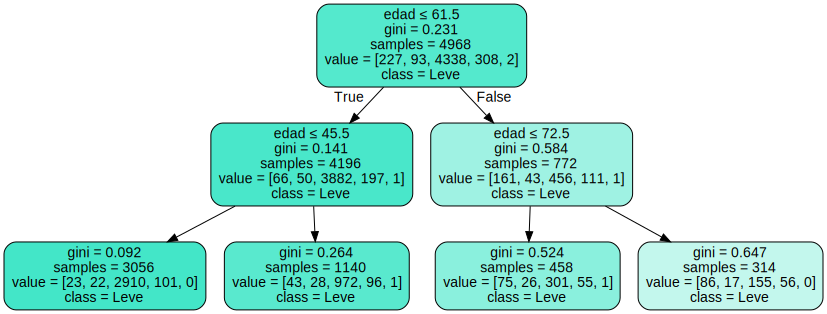

In [11]:
#Graficación del primer árbol
data_graph_t1=tree.export_graphviz(cl, out_file=None, feature_names=['edad','sexo'],
                                   class_names=['Fallecido', 'Grave', 'Leve', 'Moderado'],
                                   filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(data_graph_t1, format='png')
graph

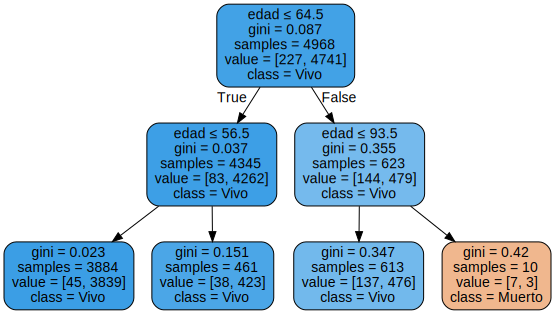

In [12]:
#Graficación del segundo árbol
data_graph_t2=tree.export_graphviz(cl_simp, out_file=None, feature_names=['edad','sexo'],
                                   class_names=['Muerto', 'Vivo'],
                                   filled=True, rounded=True, special_characters=True)
graph2 = graphviz.Source(data_graph_t2, format='png')
graph2

In [13]:
graph.render('Árbol gravedad 4 de mayo')
graph2.render('Árbol mortalidad 4 de mayo')

'Árbol mortalidad 4 de mayo.png'